In [4]:
import pandas as pd 
import numpy as nm
import seaborn as sns
%matplotlib inline

Загружаем представленные для задания таблицы 

In [5]:
lectures_df=pd.read_csv('/Users/mikhailgubanov/Yandex.Disk-gubanov.mn@phystech.edu.localized/HW_Pandas/lectures.csv',sep=',')
questions_df=pd.read_csv('/Users/mikhailgubanov/Yandex.Disk-gubanov.mn@phystech.edu.localized/HW_Pandas/questions.csv',sep=',')
train_df=pd.read_csv('/Users/mikhailgubanov/Yandex.Disk-gubanov.mn@phystech.edu.localized/HW_Pandas/train.csv',sep=',',nrows=1000000)


### Оцeниваем содержание основной таблицы (train)

* **row_id** : (int64) Идентификационный код для строки. # *можно удалить - не информативно* 
* **timestamp**: (int64) время в миллисекундах между этим пользовательским взаимодействием и первым завершением события от этого пользователя. **время в миллисекундах. с момента ответа на первый вопрос**
* **user_id**: (int32) Идентификационный код вопроса или лекции.
* **content_id**: (int16) Идентификационный код для пользовательского взаимодействия
* **content_type_id**: (int8) 0, если событием был заданный пользователю **question**, 1, если событием был пользователь, просматривающий **lecture**.
* **task_container_id**: (int16) Идентификационный код для группы вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем увидит пояснения к любому из них. Все эти три будут иметь общий идентификатор task_container_id.
* **user_answer**: (int8) ответ пользователя на вопрос, если таковой имеется. Считайте -1 как null, для лекций.
* **answered_correctly**: (int8) если пользователь ответил правильно. Считайте -1 как null, для лекций.
* **prior_question_elapsed_time**: **(время ответа на вопрос)** (float32) Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущем блоке вопросов, игнорируя любые лекции между ними. Равно нулю для первого пакета вопросов пользователя или лекции. Обратите внимание, что время - это среднее время, затраченное пользователем на решение каждого вопроса в предыдущем пакете.
* **prior_question_had_explanation**: (**был ли объяснен предыдущий вопрос**) (bool) смотрел ли пользователь обьяснение и правильный ответ на предидущий вопрос 

In [50]:
# оцениваем содержание таблицы, с точки зрения содержания информативности и формата данных.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   timestamp                       1000000 non-null  int64   
 1   user_id                         1000000 non-null  int64   
 2   content_id                      1000000 non-null  int64   
 3   content_type_id                 1000000 non-null  category
 4   task_container_id               1000000 non-null  int64   
 5   user_answer                     1000000 non-null  category
 6   answered_correctly              1000000 non-null  category
 7   prior_question_elapsed_time     976277 non-null   float64 
 8   prior_question_had_explanation  996184 non-null   category
dtypes: category(4), float64(1), int64(4)
memory usage: 42.0 MB


In [83]:
train_df[train_df['user_id']==115].sort_values(['user_id','timestamp','content_id']).describe()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,4.600000e+01,46.0,46.000000,46.0,46.000000,46.000000,46.000000,45.000000
mean,1.021248e+08,115.0,3598.173913,0.0,22.239130,1.565217,0.695652,19933.311111
std,2.423906e+08,0.0,3595.928372,0.0,13.023372,1.147987,0.465215,7103.367533
min,0.000000e+00,115.0,4.000000,0.0,0.000000,0.000000,0.000000,5000.000000
25%,2.857732e+05,115.0,133.750000,0.0,11.250000,1.000000,0.000000,17000.000000
50%,5.459320e+05,115.0,2064.500000,0.0,22.500000,2.000000,1.000000,20000.000000
75%,1.276226e+06,115.0,7892.500000,0.0,33.750000,3.000000,1.000000,22000.000000
max,6.680900e+08,115.0,7984.000000,0.0,41.000000,3.000000,1.000000,55000.000000


### ''' Оптимизируем размер таблицы, используемой для анализа данных (trian) '''

Переводим часть данных в **category** в результате, обьем занимаемых данных сокращается на 32%. 
В нашем примере с 68 МБ, до 42мб. (после удаления лиших столбцов)

In [107]:
# проверия столбцы на количество уникальных значений в каждом столбце.
# создаём пустой список
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in train_df.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, train_df[col].nunique(),train_df[col].dtype) 
    # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
unique_counts

,Column_Name,Num_Unique,Type
0,content_type_id,2,category
1,prior_question_had_explanation,2,category
2,answered_correctly,3,category
3,user_answer,5,category
4,prior_question_elapsed_time,1659,float64
5,user_id,3824,int64
6,task_container_id,7740,int64
7,content_id,13320,int64
8,timestamp,769357,int64


In [9]:
max_unique_count = 6 # задаём максимальное число уникальных категорий
for col in train_df.columns: # цикл по именам столбцов
    if train_df[col].nunique() < max_unique_count: # проверяем условие
        train_df[col] = train_df[col].astype('category') # преобразуем тип столбца
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   timestamp                       1000000 non-null  int64   
 1   user_id                         1000000 non-null  int64   
 2   content_id                      1000000 non-null  int64   
 3   content_type_id                 1000000 non-null  category
 4   task_container_id               1000000 non-null  int64   
 5   user_answer                     1000000 non-null  category
 6   answered_correctly              1000000 non-null  category
 7   prior_question_elapsed_time     976277 non-null   float64 
 8   prior_question_had_explanation  996184 non-null   category
dtypes: category(4), float64(1), int64(4)
memory usage: 42.0 MB


None

### Блок  2 - удаляем не информативные столбцы.

In [281]:
train_df=train_df.drop(['user_answer'],axis=1) # удаляем не информативные столбцы user_answer и идентификатр строки.

In [43]:
# анализируем ответы пользователей (без учета лекций)
train_df['answered_correctly'][train_df['answered_correctly']!=-1].value_counts(normalize=True)*100
# 65% ответов пользователей верные. 

1     65.035767
0     34.964233
-1     0.000000
Name: answered_correctly, dtype: float64

In [44]:
#98% активности пользователя - это ответы на вопросы 
train_df['content_type_id'].value_counts(normalize=True)*100

0    98.0093
1     1.9907
Name: content_type_id, dtype: float64

In [32]:
# формируем фильтр для оценки количества верных ответов
correctly_filter=train_df['answered_correctly'][train_df['answered_correctly']==1] 
# количество ошибочных ответов 
mistake_filter=train_df['answered_correctly'][train_df['answered_correctly']==0]
# количество проведенных лекций
lec_filter=train_df['answered_correctly'][train_df['answered_correctly']==-1]

In [65]:
(train_df['prior_question_elapsed_time']/1000).describe()

count    976277.000000
mean         25.302963
std          19.710310
min           0.000000
25%          16.000000
50%          21.000000
75%          29.666000
max         300.000000
Name: prior_question_elapsed_time, dtype: float64

* В среднем на вопрос затрачивается около **25** секунд (на ограниченной выборке)
* максимальное время ответа 300 сек
* медиана на уровне 21 сек
* стандартное отклонение 19 сек

### Проанализируем успеваемость студента 
* правильность ответа в зависимости полученной консультации 
* средний бал, в зависимости от скорости ответов на вопросы
* количество првильныз ответов в зависимости от пройденного времени с начала теста 

In [150]:
#настраиваем фильтры 
Filter_corectly=train_df['answered_correctly']==1
Filter_mistake=train_df['answered_correctly']==0
no_had_explanation_filter=train_df['prior_question_had_explanation']==0
ya_had_explanation_filter=train_df['prior_question_had_explanation']==1

Пользователи получающие консультацию на предыдущий вопрос (видящие ответы на предыдущий вопрос, в нашей выборке)дают в два раза больше верных ответов, в сравнении с неверными. При этом при в отсуствии консультации зависимости не наблюдается


<AxesSubplot:>

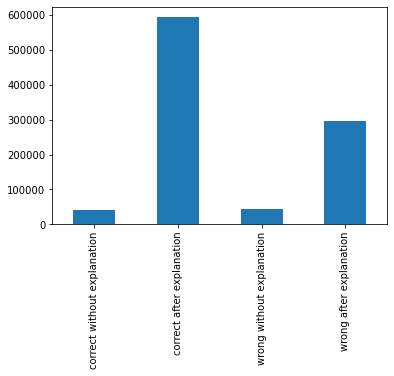

In [279]:
# формируем фильтрованные данные для построения графика
a=train_df[Filter_corectly & no_had_explanation_filter]['user_id'].count()
b=train_df[Filter_corectly & ya_had_explanation_filter]['user_id'].count()
c=train_df[Filter_mistake & no_had_explanation_filter]['user_id'].count()
d=train_df[Filter_mistake & ya_had_explanation_filter]['user_id'].count()

# на основе полученных данных создаем обекс Series
s=pd.Series([a,b,c,d], index=['correct without explanation','correct after explanation','wrong without explanation','wrong after explanation'])

print('Пользователи получающие консультацию на предыдущий вопрос (видящие ответы на предыдущий вопрос, в нашей выборке)'
      'дают в два раза больше верных ответов, в сравнении с неверными. При этом при в отсуствии консультации зависимости не наблюдается', sep='/n')


s.plot(kind='bar')

In [ ]:
составим таблицу с параметрами студентов

In [164]:
sudents_list = list(train_df['user_id'].unique()) # создаем список студентов 

In [172]:
# среднее время затраченное на ответ на вопрос.
qv_time = []
for student in sudents_list:
    t = train_df[(train_df['user_id'] == student) & (train_df['answered_correctly'] != -1)]['prior_question_elapsed_time'].mean()
    g=round((t/1000),2)
    qv_time.append(g)
    


In [183]:
# средний балл
mean_grade = []
for student in sudents_list:
    g = train_df[(train_df['user_id'] == student) & (train_df['answered_correctly'] != -1)]['answered_correctly'].astype(int).mean()
    
    mean_grade.append(round(g,2))


In [ ]:
# общее время проведенное на платформе
all_time = []
for student in sudents_list:
    at = train_df[(train_df['user_id'] == student)]['timestamp'].max()
    am=round((at/60000),2)
    all_time.append(am)


In [184]:
# количество отвеченых вопросов 
ques_quant = []
for student in sudents_list:
    q = train_df[(train_df['user_id'] == student) & (train_df['content_type_id'] == 0)]['content_type_id'].count()
    ques_quant.append(q)

In [234]:
# количество прослушанных лекций  
lec_wached = []
for student in sudents_list:
    l = train_df[(train_df['user_id'] == student) & (train_df['content_type_id'] == 1)]['content_type_id'].astype(int).sum()
    lec_wached.append(l)
   
        


In [209]:
# количество верных ответов, после разьяснений предsдущего вопроса

exp_qv=[]
for student in sudents_list:
    exp=train_df[(train_df['user_id'] == student) & Filter_corectly & ya_had_explanation_filter]['answered_correctly'].count()
    exp_qv.append(exp)



### Создадим df c данными о студентах (используем сведения о 3824 студентах)

In [235]:
studenst_df=pd.DataFrame({'user id': sudents_list,
                          'qv_time':qv_time,
                          'mean_grade':mean_grade,
                          'all_time':all_time,
                          'ques_quant':ques_quant,
                          'lec_wached':lec_wached,
                          'exp_qv':exp_qv
                         }
                        )



In [244]:
studenst_df.describe()

,user id,qv_time,mean_grade,all_time,ques_quant,lec_wached,exp_qv
count,3.824000e+03,3822.000000,3824.00000,3.824000e+03,3824.000000,3824.000000,3824.000000
mean,1.050633e+07,23.985641,0.54511,8.917850e+04,256.300471,5.205805,154.965220
std,5.958653e+06,8.134100,0.16563,1.785751e+05,693.454534,16.945197,462.885457
min,1.150000e+02,1.000000,0.00000,0.000000e+00,1.000000,0.000000,0.000000
25%,5.363199e+06,19.210000,0.43000,1.882750e+01,30.000000,0.000000,3.000000
50%,1.061051e+07,22.770000,0.57000,5.839760e+03,41.000000,0.000000,14.000000
75%,1.565077e+07,27.332500,0.67000,8.384158e+04,156.000000,2.000000,85.000000
max,2.094902e+07,96.440000,1.00000,1.301533e+06,10797.000000,306.000000,6191.000000


<AxesSubplot:xlabel='lec_wached', ylabel='mean_grade'>

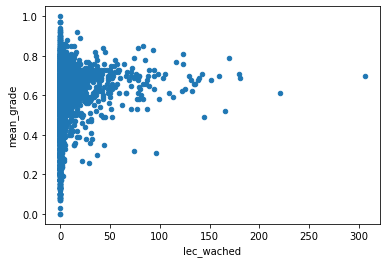

In [236]:
# прямого влияния на средний балл количества просмотренных лекций не наблюдается 

studenst_df.plot(x='lec_wached', y='mean_grade',kind="scatter")

<AxesSubplot:title={'center':'mean_grade'}, xlabel='[lec_wached]'>

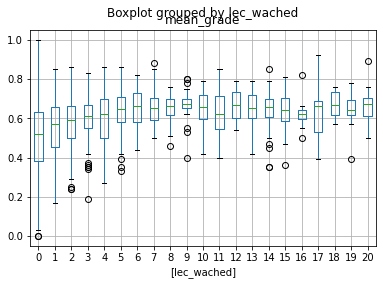

In [292]:
"""
Построим диаграмму размаха, показывающую зависимость правильных ответов от кол-ва просмотренных лекций
"""
studenst_df[studenst_df['lec_wached'] < 21].boxplot(column=['mean_grade'], by=['lec_wached'])



<AxesSubplot:xlabel='qv_time', ylabel='mean_grade'>

'\nНет очевидной прямой зависимость среднего балла студента, от скорости ответа на вопрос. \n\nОднако мы можем наблюдать эффективный коридод фактически полностью повторяющий медианое значение,\nс учетом стандартного отклонения. Студенты отвечающие на вопросы быстрее этих границ или существенно дольше \nимееют более низкий балл. \n\nМожно сформировать гиппотезу, что студенты затрачивающие больше времени на подготовку ответа менее подготовлены.\nЛибо менее мотивированы. \nТо же самое моно сказать о студентах слишком быстро предоставляющих ответы на вопросы.\n\n'

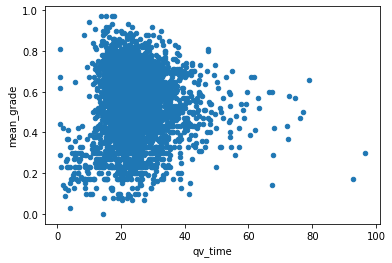

In [248]:
display(studenst_df)xlabel='qv_time', ylabel='mean_grade'

'''
Нет очевидной прямой зависимость среднего балла студента, от скорости ответа на вопрос. 

Однако мы можем наблюдать эффективный коридод фактически полностью повторяющий медианое значение,
с учетом стандартного отклонения. Студенты отвечающие на вопросы быстрее этих границ или существенно дольше 
имееют более низкий балл. 

Можно сформировать гиппотезу, что студенты затрачивающие больше времени на подготовку ответа менее подготовлены.
Либо менее мотивированы. 
То же самое моно сказать о студентах слишком быстро предоставляющих ответы на вопросы.

'''

<AxesSubplot:xlabel='all_time', ylabel='mean_grade'>

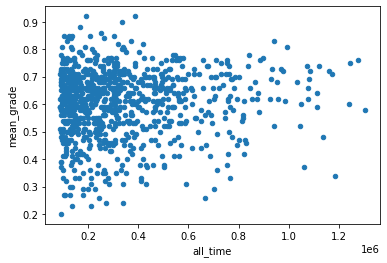

In [277]:
# Прямой зависимости - среднего балла ко времени проведенному на портале не наблюдается.

studenst_df[studenst_df['all_time']>90000].plot(x='all_time', y='mean_grade',kind="scatter")

<AxesSubplot:>

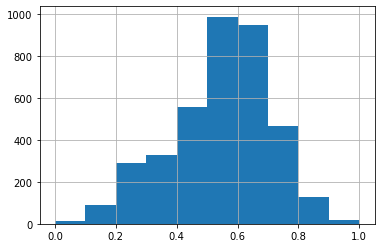

In [240]:
# посмотрим на гистограмму распределения оценок среди студентов
studenst_df['mean_grade'].hist(bins=10)

<AxesSubplot:xlabel='mean_grade', ylabel='exp_qv'>

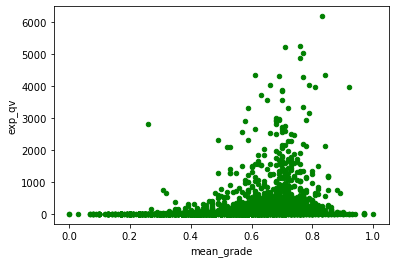

In [278]:
"""
построим диаграмму рассеивания и попробуем найти зависимость между долей верных ответов и консультаций.
Можно предположить, что студенты анализирующие ответы на предыдущие вопросы имеют средний бал выше.
Что подтверждает гиппотезу заявленную выше.
"""

studenst_df.plot(x='mean_grade', y='exp_qv',kind="scatter",c='green')


In [255]:
studenst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user id     3824 non-null   int64  
 1   qv_time     3822 non-null   float64
 2   mean_grade  3824 non-null   float64
 3   all_time    3824 non-null   float64
 4   ques_quant  3824 non-null   int64  
 5   lec_wached  3824 non-null   int64  
 6   exp_qv      3824 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 209.2 KB


### Проверяем данные во вспомогательных таблицах

**QUESTIONS.CSV: МЕТАДАННЫЕ ДЛЯ ВОПРОСОВ, ЗАДАННЫХ ПОЛЬЗОВАТЕЛЯМ.**

* **question_id**: внешний ключ для столбца train/test content_id, когда тип содержимого - question (0).
* **bundle_id**: код, по которому вопросы объединяются в группы 9675 групп вопросов
* **correct_answer**: ответ на вопрос. Можно сравнить со столбцом train user_answer, чтобы проверить, был ли пользователь прав. # *не информативно для нас, поскольку есть данные в основной таблице*
* **part**: соответствующий раздел теста TOEIC. Всего 7 разделов теста. 
* **tags**: один или несколько подробных кодов тегов для вопроса. Значение тегов предоставлено не будет, но этих кодов достаточно для объединения вопросов воедино.

In [284]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  13523 non-null  int64 
 1   bundle_id    13523 non-null  int64 
 2   part         13523 non-null  int64 
 3   tags         13522 non-null  object
dtypes: int64(3), object(1)
memory usage: 422.7+ KB


In [87]:
questions_df['tags'].nunique()

1519

Можем удалить в этой таблице поле верный ответ. Поскольку оно является излишним.correct_answer в основной таблице мы уже получили данные о том, верно или нет отвечал пользователь. Номер ответа. значения в данных, на мой взгляд не имеет

In [283]:
questions_df=questions_df.drop(['correct_answer'],axis=1)

In [17]:
questions_df[['tags','part','question_id']].groupby(['tags'], as_index=False).count().sort_values(['tags','part'])

,tags,part,question_id
0,1,413,413
1,1 162,9,9
2,10 111 92,1,1
3,10 164 102,1,1
4,10 164 162 29,1,1
...,...,...,...
1514,98 97 21,11,11
1515,98 97 35 117 122 162,2,2
1516,98 97 35 146 122,6,6
1517,98 97 46 135,2,2


In [314]:
'''
проведем обьединение таблицы с вопросами с целью провети оценку сложности каждого блока вопросов
'''

tmp_df = train_df.loc[(train_df.content_type_id == 0), ['content_id', 'answered_correctly']]
mtmt_df=tmp_df.merge(questions_df, how = 'right',left_on='content_id', right_on='question_id')
display(mtmt_df)

,content_id,answered_correctly,question_id,bundle_id,part,tags
0,0.0,1,0,0,1,51 131 162 38
1,0.0,1,0,0,1,51 131 162 38
2,0.0,1,0,0,1,51 131 162 38
3,0.0,1,0,0,1,51 131 162 38
4,0.0,1,0,0,1,51 131 162 38
...,...,...,...,...,...,...
980535,13522.0,0,13522,13522,5,55
980536,13522.0,1,13522,13522,5,55
980537,13522.0,1,13522,13522,5,55
980538,13522.0,1,13522,13522,5,55


In [319]:
mtmt_df['answered_correctly']=mtmt_df['answered_correctly'].astype('float')

In [323]:
'''
Можно сделать вывод, что по мере продвижения, от части к части сложность вопросов растет - это можно увидеть 
из снижающегося среднего балла. На основе нашей выборки. (для снижения нагрузки на процессор загружено 10000000 строк) 
'''

mtmt_df[['part','answered_correctly']].groupby(['part'], as_index=False).mean().sort_values(['part','answered_correctly',])

,part,answered_correctly
0,1,0.735834
1,2,0.707258
2,3,0.692096
3,4,0.620959
4,5,0.606321
5,6,0.650695
6,7,0.645141


In [328]:
mtmt_df[['part','answered_correctly']].groupby(['part'], as_index=False).describe()

'''
7 частей заданий имеют не равномерное количество вопросов. Учитывая, что у нас нет данных о влиянии ответа 
можем предположить, что наибольшее влияние на итоговый средний бал оказывает блок номер 4. Так как содержит 
наибольшее количество вопросов. 
'''

part                                    answered_correctly            \
      count mean  std  min  25%  50%  75%  max              count      mean   
0   69499.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0            69411.0  0.735834   
1  190740.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0           190731.0  0.707258   
2   82274.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0            82175.0  0.692096   
3   76141.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0            75997.0  0.620959   
4  403284.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0           403240.0  0.606321   
5  108572.0  6.0  0.0  6.0  6.0  6.0  6.0  6.0           108567.0  0.650695   
6   50030.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0            49972.0  0.645141   

                                      
        std  min  25%  50%  75%  max  
0  0.440891  0.0  0.0  1.0  1.0  1.0  
1  0.455022  0.0  0.0  1.0  1.0  1.0  
2  0.461629  0.0  0.0  1.0  1.0  1.0  
3  0.485152  0.0  0.0  1.0  1.0  1.0  
4  0.488566  0.0  0.0  1.0  1.0  1.0  
5  0.476753  0.0  0.0  1.0  1.0  1.0  
6  0.478475  0.0  0.0  1.0  1.0  1.0

In [322]:
mtmt_dfgroupby('part')

**LECTURES.CSV: МЕТАДАННЫЕ ДЛЯ ЛЕКЦИЙ, КОТОРЫЕ ПРОСМАТРИВАЮТ ПОЛЬЗОВАТЕЛИ ПО МЕРЕ ПРОДВИЖЕНИЯ В СВОЕМ ОБРАЗОВАНИИ.**

* **lecture_id**: внешний ключ для столбца train/test content_id, когда тип содержимого - lecture (1).
* **part**: код категории верхнего уровня для лекции.
* **tags**: один тег кодирует лекцию. Значение тегов не будет указано, но этих кодов достаточно для объединения лекций в кластеры.
* **type_of**: краткое описание основной цели лекции.

In [38]:
lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [333]:
lectures_df[['type_of','part','lecture_id','tag']].groupby(['type_of','part'],as_index=False).count().sort_values(by=['type_of','part'])

'''
В лекциях мы так же как и в вовпросах, видим 7 групп. Делятся на концептуальные лекции, практические занятие, вводные
'''


,type_of,part,lecture_id,tag
0,concept,1,20,20
1,concept,2,18,18
2,concept,3,7,7
3,concept,4,19,19
4,concept,5,72,72
5,concept,6,63,63
6,concept,7,23,23
7,intention,2,7,7
8,solving question,1,34,34
9,solving question,2,31,31


<AxesSubplot:ylabel='type_of'>

'\nОсновная доля лекционных материалов - это лекции и решение практических задач. Доля других существенно ниже\n'

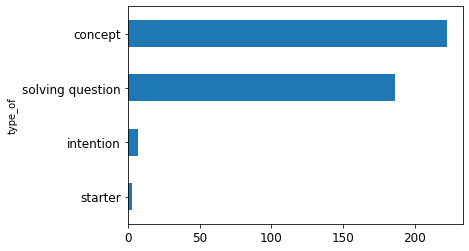

In [347]:
cat_totals = lectures_df.groupby("type_of")["lecture_id"].count().sort_values()
display(cat_totals.plot(kind="barh", fontsize=12))
'''
Основная доля лекционных материалов - это лекции и решение практических задач. Доля других существенно ниже
'''

<AxesSubplot:xlabel='part', ylabel='Count'>

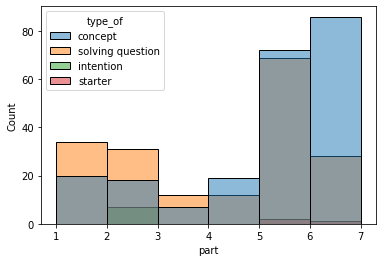

In [364]:
# Первые три группы обучения .практико ориентированы. Далее преобладают теоретических занятий 
sns.histplot(data=lectures_df,x='part', hue = 'type_of', bins=6)